In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import optimizers
from keras import backend as K
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import gc
import glob
import tensorflow as tf 
import pcap_processor
import numpy as np
import pandas as pd
import cic_2017_setup
import cic_2018_setup

gc.collect()

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


0

In [2]:
full_data, training_data = cic_2017_setup.setup()

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning:

Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning:

Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
#one hot encode labels
def one_hot_encode_malicious_type(labels):
    labelencoder = LabelEncoder()
    y_labels_as_int_list = []
    for label in labels:
        if label == "Infiltration":
            y_labels_as_int_list.append(1)
        elif label == "DoS Hulk":
            y_labels_as_int_list.append(2)
        elif label == "DDoS":
            y_labels_as_int_list.append(3)
        elif label == "DoS GoldenEye":
            y_labels_as_int_list.append(4)
        elif label == "FTP-Patator":
            y_labels_as_int_list.append(5)
        elif label == "SSH-Patator":
            y_labels_as_int_list.append(6)
        elif label == "DoS slowloris":
            y_labels_as_int_list.append(7)
        elif label == "DoS Slowhttptest":
            y_labels_as_int_list.append(8)
        elif label == "Bot":
            y_labels_as_int_list.append(9)
        elif label == "Web Attack � Brute Force":
            y_labels_as_int_list.append(10)
        elif label == "Web Attack � XSS":
            y_labels_as_int_list.append(11)
        elif label == "Web Attack � Sql Injection ":
            y_labels_as_int_list.append(12)
        elif label == "Heartbleed":
            y_labels_as_int_list.append(13)   
        else:
            y_labels_as_int_list.append(0)
    y_labels_encoded = to_categorical(y_labels_as_int_list)
    #y_labels_encoded = labelencoder.fit_transform(y_labels_as_int_list)
    return y_labels_encoded

def one_hot_encode_class_type(labels):
    labelencoder = LabelEncoder()
    y_labels_as_int_list = []
    for label in labels:
        if label != "BENIGN":
            y_labels_as_int_list.append(1)
        else:
            y_labels_as_int_list.append(0)
    y_labels_encoded = to_categorical(y_labels_as_int_list)
    #_labels_encoded = labelencoder.fit_transform(y_labels_as_int_list)
    return y_labels_encoded
            

In [4]:
training_labels = training_data["labels"]
training_data = training_data.drop(labels="labels", axis=1)

full_labels = full_data["labels"]
full_data = full_data.drop(labels="labels", axis=1)

In [5]:
import matplotlib as plt

pca_training_labels = training_labels
X_std = StandardScaler().fit_transform(training_data)
X_std = pd.DataFrame(X_std)
pca_training_labels = pca_training_labels.reset_index(drop=True)
X_std["labels"] = pca_training_labels
X_std.dropna(inplace=True)
pca_training_labels = X_std["labels"]
X_std.drop(labels="labels", axis=1, inplace=True)

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



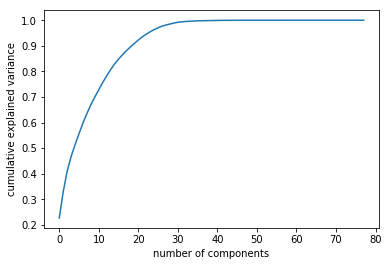

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [12]:
#X_std.drop(labels="labels", axis=1, inplace=True)
pca_training_labels = training_labels
X_std = StandardScaler().fit_transform(training_data)
X_std = pd.DataFrame(X_std)
pca_training_labels = pca_training_labels.reset_index(drop=True)
X_std["labels"] = pca_training_labels
X_std.dropna(inplace=True)
pca_training_labels = X_std["labels"]
X_std.drop(labels="labels", axis=1, inplace=True)
sklearn_pca = PCA(n_components=25)
pca_training_data = sklearn_pca.fit_transform(X_std)

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [13]:
pca_training_data.shape

(1113631, 25)

In [14]:
nn_input_dim = len(pca_training_data[1])
nn_input_dim

25

In [15]:
neural_network = Sequential()
neural_network.add(Dense(32, input_dim=nn_input_dim, activation="relu"))
neural_network.add(BatchNormalization())
neural_network.add(Dense(64, activation="relu"))
neural_network.add(Dropout(.2))
neural_network.add(BatchNormalization())
neural_network.add(Dense(96, activation="relu"))
neural_network.add(Dropout(.2))
neural_network.add(BatchNormalization())
neural_network.add(Dense(2))
neural_network.add(Activation(tf.nn.softmax))

In [16]:
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))




optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
neural_network.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [17]:
neural_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 96)                6240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
__________

In [18]:
def training_kfold(x, y, neural_network, n=5, epochs=10, batch_size=512, shuffle=True, random_state=None):
    
    from sklearn.model_selection import StratifiedKFold

    kfold = StratifiedKFold(n_splits=n, shuffle=True, random_state = random_state)
    cvscores = []
    
    for train, test in kfold.split(x, y):
    
        y_labels_encoded = one_hot_encode_class_type(y)
        neural_network.model.fit(x.iloc[train], y_labels_encoded[train], epochs=epochs, batch_size=batch_size)
        scores = neural_network.evaluate(x.iloc[test], y_labels_encoded[test])
        print("%s: %.2f%%" % (neural_network.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print(cvscores)
    return neural_network

def training_standard(x, y, neural_network, epochs=10, batch_size=512):
    '''
    class_weight = {0: 1,
                    1: 50,
                    2: 50,
                    3: 50,
                    4: 50,
                    5: 50,
                    6: 50,
                    7: 50,
                    8: 50,
                    9: 50,
                    10: 50,
                    11: 50,
                    12: 50,
                    13: 50,
                    14: 50,
                    15: 50}
    '''
    #class_weight = {[1,0]: 1,
    #                [0,1]: 100}
    
    #normalize x
    #x = (x - x.mean()) / (x.max() - x.min())
    y_labels_encoded = one_hot_encode_class_type(y)
    neural_network.model.fit(x, y_labels_encoded, epochs=epochs, batch_size=batch_size, shuffle=True)
    return neural_network

- Combine lables and data dataframes
- Save all maclicious traffic to maclicious_traffic
- Drop non-benign traffic from data
- Append 2/3 of random benign samples to training_data
- Train on training_data

In [19]:
neural_network = training_standard(pca_training_data, pca_training_labels, neural_network, epochs=15, batch_size=64)

Epoch 1/15
1113631/1113631 [==============================] - 112s 101us/step - loss: 0.1651 - acc: 0.9368
Epoch 2/15
1113631/1113631 [==============================] - 112s 100us/step - loss: 0.1100 - acc: 0.9598
Epoch 3/15
1113631/1113631 [==============================] - 108s 97us/step - loss: 0.0947 - acc: 0.9664
Epoch 4/15
1113631/1113631 [==============================] - 121s 109us/step - loss: 0.0859 - acc: 0.9696
Epoch 5/15
1113631/1113631 [==============================] - 112s 101us/step - loss: 0.0801 - acc: 0.9719
Epoch 6/15
1113631/1113631 [==============================] - 107s 96us/step - loss: 0.0760 - acc: 0.9734
Epoch 7/15
1113631/1113631 [==============================] - 106s 95us/step - loss: 0.0728 - acc: 0.9748
Epoch 8/15
1113631/1113631 [==============================] - 105s 94us/step - loss: 0.0702 - acc: 0.9756
Epoch 9/15
1113631/1113631 [==============================] - 105s 94us/step - loss: 0.0675 - acc: 0.9766
Epoch 10/15
1113631/1113631 [=============

In [20]:
neural_network.evaluate(x=pca_training_data, y=one_hot_encode_class_type(pca_training_labels), batch_size=128)

1113631/1113631 [==============================] - 29s 26us/step


[0.10119423111870308, 0.963205047272486]

In [21]:
def pca_reduce(_data):

    _X_std = StandardScaler().fit_transform(_data)
    _X_std = pd.DataFrame(_X_std)
    _sklearn_pca = PCA(n_components=5)
    _pca_data = _sklearn_pca.fit_transform(_X_std)
    return _pca_data

In [22]:
y_predictions = neural_network.predict(pca_training_data)
y_labels_encoded = one_hot_encode_class_type(pca_training_labels)

In [23]:
from sklearn import metrics

y_category_labels = []
y_category_predictions = []

for predictions in y_predictions:
    if predictions[0] > predictions[1]:
        y_category_predictions.append(0)
    else:
        y_category_predictions.append(1)
        
for label in y_labels_encoded:
    if label[0] == 1:
        y_category_labels.append(0)
    else:
        y_category_labels.append(1)

        
cm = metrics.confusion_matrix(y_category_labels, y_category_predictions)

In [24]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

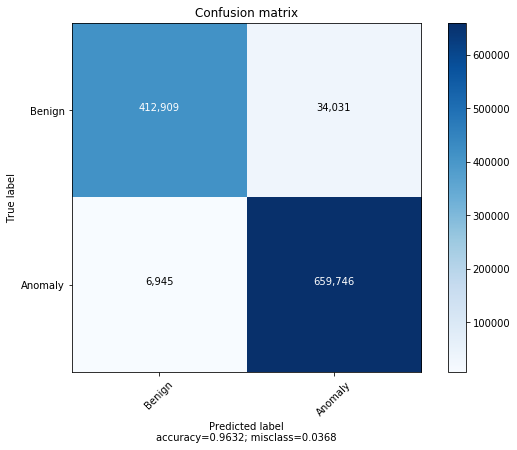

In [25]:
plot_confusion_matrix(cm, target_names = ["Benign", "Anomaly"], normalize=False)

In [27]:
gc.collect()
pca_full_labels = full_labels
X_std = StandardScaler().fit_transform(full_data)
X_std = pd.DataFrame(X_std)
pca_full_labels = pca_full_labels.reset_index(drop=True)
X_std["labels"] = pca_full_labels
X_std.dropna(inplace=True)
pca_full_labels = X_std["labels"]
X_std.drop(labels="labels", axis=1, inplace=True)
sklearn_pca = PCA(n_components=25)
pca_full_data = sklearn_pca.fit_transform(X_std)

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/kyletopasna/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



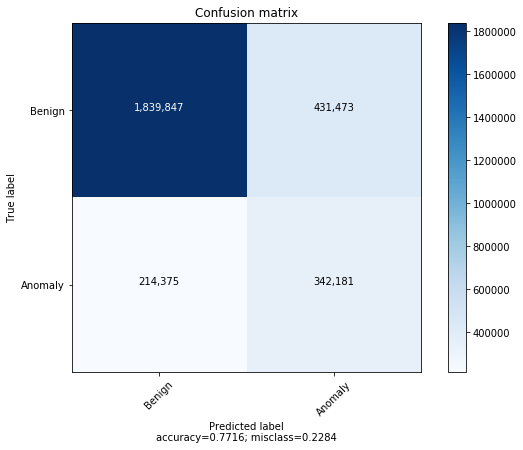

In [28]:
y_predictions = neural_network.predict(pca_full_data)
y_labels_encoded = one_hot_encode_class_type(pca_full_labels)

from sklearn import metrics

y_category_labels = []
y_category_predictions = []

for predictions in y_predictions:
    if predictions[0] > predictions[1]:
        y_category_predictions.append(0)
    else:
        y_category_predictions.append(1)
        
for label in y_labels_encoded:
    if label[0] == 1:
        y_category_labels.append(0)
    else:
        y_category_labels.append(1)

        
cm = metrics.confusion_matrix(y_category_labels, y_category_predictions)

plot_confusion_matrix(cm, target_names = ["Benign", "Anomaly"], normalize=False)

In [30]:
neural_network.save('artemis_pca_25.h5')